# Multirotor Dynamic Model

$M_b = J \dot{\omega_b} + \omega_b \times (J \omega_b)$

$\dot{\omega_b} = J^{-1}(M_b - \omega_b \times (J \omega_b))$

$F_b = m \dot{v_b} + \omega_b \times (m v_b)$

$\dot{v_b} = F_b/m -  \omega_b \times v_b$

In [11]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import control
import collections
import sys
sys.path.insert(0, '../python/pyecca')
import pyecca.lie.so3 as so3
np.set_printoptions(suppress=True, precision=3, linewidth=200)

In [12]:
class NamedSXVect(ca.SX):

    def __init__(self, symbols, names):
        super().__init__(symbols)
        self.names = names
        self.index = {}
        for i in range(len(self.names)):
            self.index[self.names[i]] = i
    
    @classmethod
    def from_string(cls, names):
        names = [name.strip() for name in names.split(',')]
        symbols = ca.vertcat(*[ca.SX.sym(name) for name in names])
        return cls(symbols, names)
            
    def __getitem__(self, key):
        if isinstance(key, int):
            return super().__getitem__(key)
        else:
            return super().__getitem__(self.index[key])

sym = ca.SX.sym('x', 3)
named_sym = NamedSXVect(sym, ['a', 'b', 'c'])
named_sym['a']

SX(x_0)

In [46]:
def quadrotor_model():
    # state space model
    
    #x: state: (angular velocity (body frame), velocity (body frame), orientation, position, motor rpms)
    x = NamedSXVect.from_string('P, Q, R, v_X, v_Y, v_Z, r0, r1, r2, p_N, p_E, p_D, duty0, duty1, duty2, duty3')
    omega_b = ca.vertcat(x['P'], x['Q'], x['R'])
    v_b = ca.vertcat(x['v_X'], x['v_Y'], x['v_Z'])
    r_nb = ca.vertcat(x['r0'], x['r1'], x['r2'], ca.SX.sym('r3'))
    p_n = ca.vertcat(x['p_N'], x['p_E'], x['p_D'])
    duty = ca.vertcat(x['duty0'], x['duty1'], x['duty2'], x['duty3'])

    #u: control
    u = NamedSXVect.from_string('u_roll, u_pitch, u_yaw, u_thrust')

    # p: parameters
    p = NamedSXVect.from_string('l, m, g, Jx, Jy, Jz, Jxz, tau, rho, r, V, kV, CT, CM')

    #y: output
    C_nb = so3.Dcm.from_mrp(r_nb)
    v_n = ca.mtimes(C_nb, v_b)
    y = NamedSXVect(ca.vertcat(x, v_n), x.names + ['v_N', 'v_E', 'v_D'])

    J = ca.SX.zeros(3, 3)
    J[0, 0] = p['Jx']
    J[1, 1] = p['Jy']
    J[2, 2] = p['Jz']
    J[0, 2] = J[2, 0] = p['Jxz']

    # forces and moments
    arm_angles_deg = [45, -135, -45, 135]
    motor_dirs = [-1, -1, 1, 1]
    mix_matrix =ca.DM([
        [-1, 1, 1, -1], # roll
        [1, -1, 1, -1], # pitch
        [1, 1, -1, -1], # yaw
        [1, 1, 1, 1] # thrust
    ])
    u_duty = ca.mtimes(ca.inv(mix_matrix), u)
    F_b = ca.mtimes(C_nb.T, ca.vertcat(0, 0, p['m']*p['g']))
    M_b = ca.SX.zeros(3)
    qs = ca.SX.zeros(4)
    i = 0
    for theta_deg, duty_i, motor_dir in zip(arm_angles_deg, duty, motor_dirs):
        theta = theta_deg*ca.pi/180
        omega = duty_i*p['V']*p['kV']*(2*ca.pi/60)
        q = p['rho']*(omega*p['r'])**2/2
        qs[i] = q
        s = ca.pi*p['r']**2
        arm_b = ca.vertcat(ca.cos(theta), ca.sin(theta), 0)
        Fi_b = ca.vertcat(0, 0, -p['CT']*q*s)
        Mi_b = ca.vertcat(0, 0, -motor_dir*p['CM']*q*s) + ca.cross(arm_b, Fi_b)
        F_b += Fi_b
        M_b += Mi_b
        i+=1

    x_dot = ca.vertcat(
        ca.mtimes(ca.inv(J), M_b - ca.cross(omega_b, ca.mtimes(J, omega_b))),
        F_b/p['m'] - ca.cross(omega_b, v_b),
        so3.Mrp.kinematics(r_nb, omega_b)[:3],
        ca.mtimes(C_nb, v_b),
        (u_duty - duty)/p['tau']
    )
    
    rhs = ca.Function('rhs', [x, u, p], [x_dot])
    forces = ca.Function('F_b', [x,u,p], [F_b])
    
    return {
        'x': x,
        'y': y,
        'x_dot': x_dot,
        'u': u,
        'p': p,
        'rhs': rhs,
        'mix': mix_matrix,
        'forces': forces,
        'q_vect': ca.Function('q_vect',[x,u,p],[qs])
    }

def trim_hover(model):
    # motor time constant 0.015 s, https://flyingmachinearena.org/wp-content/publications/2014/mueIEEE14.pdf
    p0 = ca.vertcat(1, 1, 9.8, 1, 1, 1, 0.1, 0.015, 1.225, 0.9, 11.1, 1550, 0.0000516, 1e-4)

    # TODO trim
    throt = ca.SX.sym('throt',1)
    u = np.array([0,0,0,throt])
    duties = ca.mtimes(ca.inv(model['mix']),u)
    x = ca.vertcat(0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0, 0, duties) 
    
    nlp = {'x':throt, 'f':0,'g': model['rhs'](x,u,p0)[5]}
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })
    res = S(x0=0.5, lbg=0, ubg=0)
    
    u = np.array([0,0,0,res['x']])
    duties = ca.mtimes(ca.inv(model['mix']),u)
    x = ca.vertcat(0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0, 0, duties)
    p = p0

    return x, u, p

def linearize(model, x0, u0, p0):

    # linearization
    A = ca.jacobian(model['x_dot'], model['x'])
    B = ca.jacobian(model['x_dot'], model['u'])
    C = ca.jacobian(model['y'], model['x'])
    D = ca.jacobian(model['y'], model['u'])
    f_ss = ca.Function('ss', [model['x'], model['u'], model['p']], [A, B, C, D])
    
    A0, B0, C0, D0 = f_ss(x0, u0, p0)

    sys = control.ss(A0, B0, C0, D0)
    return sys

In [47]:
# model = quadrotor_model()
# u0 = ca.vertcat(1000, 1000, 1000, 1000)
# x0 = ca.vertcat(0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0, 0, u0)
# states = ca.SX.sym('states',16)

# u = states[12:16]
# print(u)
# #nlp = {'x':states, 'f':0,'g': model['rhs'](states,states[12:15],p0)}

In [48]:
model = quadrotor_model()
x0, u0, p0 = trim_hover(model)
f = model['forces'](x0,u0,p0)
q = model['q_vect'](x0,u0,p0)
print(q)
print(f)
print(u0)
print(model['rhs'](x0,u0,p0))
sys = linearize(model, x0, u0, p0)

[18658.7, 18658.7, 18658.7, 18658.7]
[0, 0, 0]
[0.    0.    0.    0.431]
[-0, 4.44089e-16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Body Roll Rate Control


          1770
-------------------------
s^2 + 66.67 s + 5.553e-16

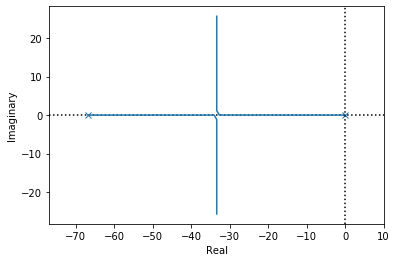

In [16]:
G_roll_rate = control.ss2tf(sys[model['y'].index['P'], model['u'].index['u_roll']])
control.rlocus(G_roll_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')
G_roll_rate

(inf, 44.342406315620536, nan, 161.75435078594717)


<Figure size 432x288 with 0 Axes>

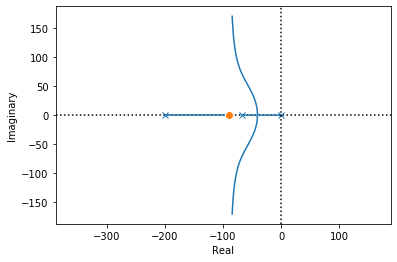

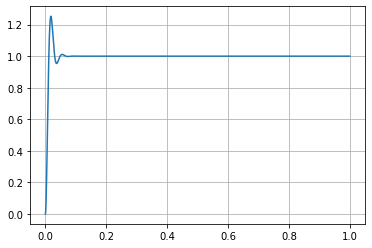

In [18]:
s = control.tf([1, 0], [0, 1])
H_roll_rate = 10*(s/90+1)/(s/200 + 1)
Go_roll_rate = G_roll_rate*H_roll_rate
print(control.margin(Go_roll_rate))

plt.figure()
control.rlocus(Go_roll_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_roll_rate = control.feedback(Go_roll_rate)

plt.figure()
t, y = control.step_response(Gc_roll_rate, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()



# Body Roll Control

(3.808742835197417, 12.562278560373215, 17.35581047691042, 8.808252479772401)


<Figure size 432x288 with 0 Axes>

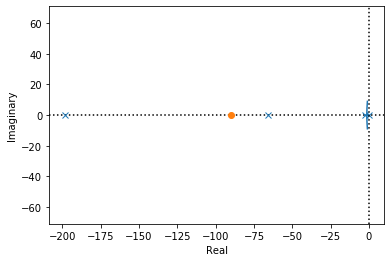

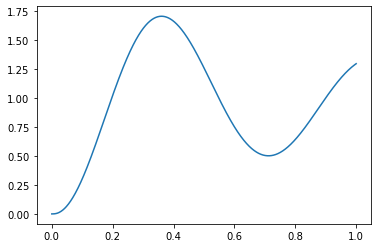

In [128]:
H_roll = 30
G_roll = Gc_roll_rate/s
Go_roll = H_roll*G_roll
Gc_roll = control.feedback(Go_roll)
print(control.margin(Go_roll))

plt.figure()
control.rlocus(Go_roll, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

plt.figure()
t, y = control.step_response(Gc_roll, np.linspace(0, 1, 1000))
plt.plot(t, y)

# Body Yaw Rate Control


          0.3575 s^2 + 5.716e-15 s - 4.573e-14
---------------------------------------------------------
s^4 + 66.67 s^3 + 9.352e-13 s^2 - 8.447e-12 s + 1.075e-11

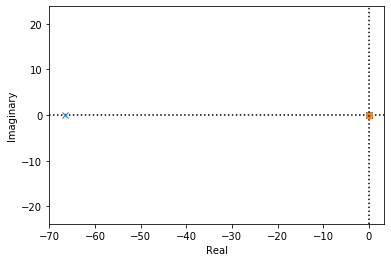

In [129]:
G_yaw_rate = control.ss2tf(sys[model['y'].index['R'], model['u'].index['u_yaw']])
control.rlocus(G_yaw_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')
G_yaw_rate

(587.8590314250265, 0.23140106104864344, 0.0, 8.663626371934768e-06)


<Figure size 432x288 with 0 Axes>

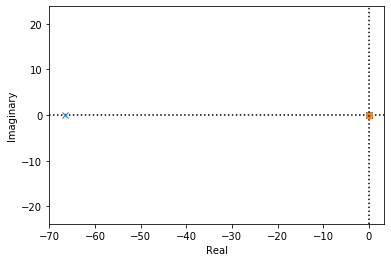

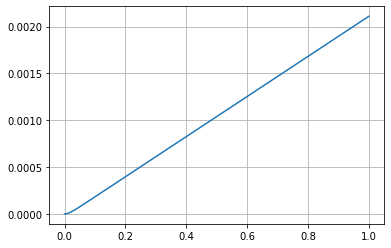

In [130]:
H_yaw_rate = 0.4
Go_yaw_rate = G_yaw_rate*H_yaw_rate
print(control.margin(Go_yaw_rate))

plt.figure()
control.rlocus(Go_yaw_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_yaw_rate = control.feedback(Go_yaw_rate)

plt.figure()
t, y = control.step_response(Gc_yaw_rate, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()

# Body Yaw Control

(4.444444442107674, 0.5310146996565663, 0.3781637566207558, 0.17937496801506117)


<Figure size 432x288 with 0 Axes>

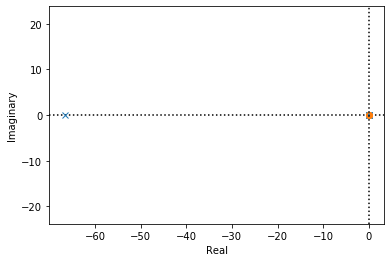

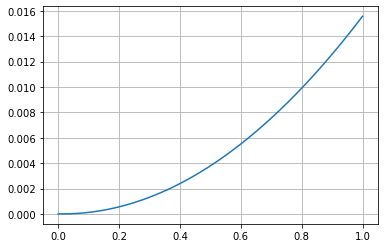

In [131]:
H_yaw = 15
G_yaw = Gc_yaw_rate/s
Go_yaw = G_yaw*H_yaw
print(control.margin(Go_yaw))

plt.figure()
control.rlocus(Go_yaw, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_yaw = control.feedback(Go_yaw)

plt.figure()
t, y = control.step_response(Gc_yaw, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()

# Climb Rate Control


    2478
-------------
s^2 + 66.67 s

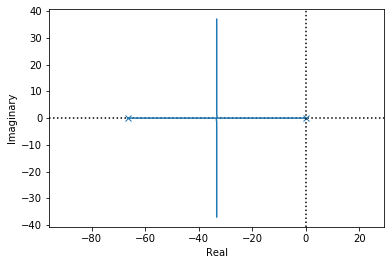

In [132]:
G_climb_rate = control.ss2tf(-sys[model['y'].index['v_D'], model['u'].index['u_thrust']])
control.rlocus(G_climb_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')
G_climb_rate

(inf, 88.40402033571957, nan, 1.857487099451951)


<Figure size 432x288 with 0 Axes>

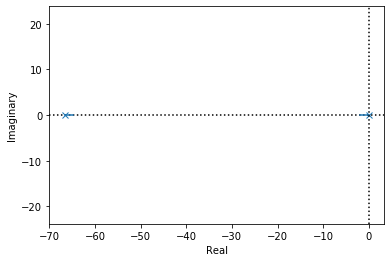

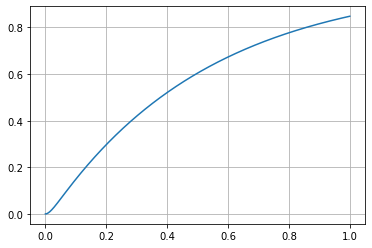

In [133]:
H_climb_rate = 0.05
Go_climb_rate = G_climb_rate*H_climb_rate
print(control.margin(Go_climb_rate))

plt.figure()
control.rlocus(Go_climb_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_climb_rate = control.feedback(Go_climb_rate)

plt.figure()
t, y = control.step_response(Gc_climb_rate, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()

In [134]:
np.linalg.matrix_rank(control.ctrb(sys.A, sys.B))

4

In [135]:
np.linalg.matrix_rank(control.ctrb(sys.A, sys.B), 1e6)

14

In [136]:
u, s, vh = np.linalg.svd(control.ctrb(sys.A, sys.B))
u

matrix([[ 0.   , -0.622,  0.   ,  0.   , -0.011,  0.153, -0.379,  0.021,  0.662,  0.085,  0.007, -0.018, -0.001, -0.   , -0.   , -0.   ],
        [-0.   ,  0.   ,  0.619,  0.   , -0.077,  0.197, -0.524, -0.433, -0.326, -0.053, -0.005,  0.008, -0.   , -0.   ,  0.   , -0.   ],
        [-0.   ,  0.062, -0.   ,  0.   , -0.969, -0.216, -0.038,  0.068,  0.067,  0.013,  0.001, -0.003, -0.   , -0.001,  0.   ,  0.   ],
        [-0.   , -0.   , -0.001,  0.   ,  0.014,  0.179, -0.428,  0.828, -0.314,  0.016, -0.001,  0.006,  0.001,  0.   ,  0.   ,  0.   ],
        [ 0.   , -0.001,  0.   ,  0.   , -0.001, -0.   , -0.   , -0.002,  0.002,  0.017,  0.115,  0.182,  0.51 ,  0.832,  0.013,  0.007],
        [ 0.744,  0.   , -0.   , -0.   ,  0.144, -0.603, -0.247, -0.   , -0.   ,  0.004,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ],
        [-0.   ,  0.002, -0.   , -0.   ,  0.001,  0.   ,  0.   ,  0.002, -0.008, -0.03 , -0.627, -0.748,  0.11 ,  0.184,  0.   ,  0.005],
        [ 0.   , -0.   , -0.002,  

In [137]:
model['x'].index

{'P': 0,
 'Q': 1,
 'R': 2,
 'v_X': 3,
 'v_Y': 4,
 'v_Z': 5,
 'r0': 6,
 'r1': 7,
 'r2': 8,
 'p_N': 9,
 'p_E': 10,
 'p_D': 11,
 'duty0': 12,
 'duty1': 13,
 'duty2': 14,
 'duty3': 15}

In [138]:
K, S, E = control.lqr(sys.A, sys.B, np.eye(16), np.eye(4))
K

array([[ 1.299, -0.   ,  0.   ,  0.   ,  1.497,  0.   , 24.353, -0.   ,  0.   ,  0.   ,  1.   ,  0.   , -0.511,  0.511,  0.511, -0.511],
       [-0.   ,  1.296, -0.   , -1.497, -0.   , -0.   , -0.   , 24.324, -0.   , -1.   ,  0.   ,  0.   ,  0.507, -0.507,  0.507, -0.507],
       [ 1.031, -0.   , 10.313, -0.   , -0.   , -0.   ,  0.101, -0.   ,  1.   , -0.   , -0.   , -0.   ,  0.119,  0.119, -0.119, -0.119],
       [ 0.   ,  0.   ,  0.   , -0.   ,  0.   , -1.041,  0.   ,  0.   ,  0.   , -0.   ,  0.   , -1.   ,  0.553,  0.553,  0.553,  0.553]])